In [1]:
import sys
import os
import warnings
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path 

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]
target_names = ['Group Size Disparity', 'Prevalence Disparity', 'Equal Opportunity', 
                'Disparate Parity', 'Individual Fairness', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(bias_score_key, target_names_w))

In [4]:
df_meta = pd.read_csv("artifact/metadataset.csv")

# exclude random states because they do not carry information
df_meta = df_meta.drop('dataset_random_state', axis=1)
df_meta = df_meta.drop('sensitive_random_state', axis=1)
df_meta = df_meta.drop('landmarking_random_state', axis=1)

# exclude arrays of class- or group-specific information as their shape is 
#  dataset-specific and does not generalize
df_meta = df_meta.drop('class_weight', axis=1)
df_meta = df_meta.drop('sensitive_group_scores', axis=1)

features = df_meta.columns[:-6]
targets = df_meta.columns[-6:]
target_names = ['Group Size Disparity', 'Prevalence Disparity', 'Equal Opportunity', 
                'Disparate Parity', 'Individual Fairness', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
COLORS = ['#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']
target_to_color = dict(zip(targets, COLORS))

In [7]:
cv_result_path="experiment_result/Q2b_result_balanced.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

In [8]:
cv_result_df

,Model,Fold,label,balanced,metric,on,value
0,NaiveMean,0,Group Size Disparity,True,MAE,all,0.823521
1,NaiveMean,0,Group Size Disparity,True,MAE,high,0.807258
2,NaiveMean,0,Group Size Disparity,True,MAE,low,0.839785
3,NaiveMean,0,Group Size Disparity,True,MSE,all,1.047358
4,NaiveMean,0,Group Size Disparity,True,MSE,high,1.150845
...,...,...,...,...,...,...,...
14395,MLP,9,group_fairness,False,MAPE,high,1.117317
14396,MLP,9,group_fairness,False,MAPE,low,1.054235
14397,MLP,9,group_fairness,False,SMAPE,all,1.814691
14398,MLP,9,group_fairness,False,SMAPE,high,2.000000


## Experiments

#### Step 1: Normalize targets

In [7]:
X = df_meta[features]
Y = df_meta[targets]

# Normalize Y (each column has 0 mean and 1 standard deviation)
scaler = StandardScaler()
Y_n = scaler.fit_transform(Y)
Y_n = pd.DataFrame(Y_n, columns=Y.columns)

In [8]:
#Dummy Normal Models, proved to be too irrelevent in our results
class DummyNormalPredictor:
    def __init__(self, random_state) -> None:
        self.random_state=None
        if random_state is int:
            self.random_state=random_state
        pass
    def fit(self,X,Y):
        self.mean=np.average(Y)
        self.standard_deviation=np.std(Y)
    
    def predict(self,X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.normal(self.mean,self.standard_deviation,size=X.shape[0])

#### Step 2: Binarize

In [9]:
# Targets are normalized with mean 0 and std 1
## We binarize using the sign
Y_bin = (Y_n > 0).astype(int)

In [10]:
def symmetry_mean_aboslute_percentage_error(truth,pred):
    smape = np.abs(pred - truth) / (np.abs(truth)+np.abs(pred))*2
    output_errors = np.average(smape, axis=0)
    return output_errors

In [32]:
def cross_validate(model, name, target, sample_size=1000, repetitions=10, balanced=True):
    cv_result=[]
    np.random.seed(2210)
    for index in tqdm(range(repetitions),desc=f"{name}/{target}/{balanced}"):
        if balanced:
            # draw test set
            idx1 = Y_bin.index.values[Y_bin[target]==0]
            idx2 = Y_bin.index.values[Y_bin[target]==1]
            idx1_test = np.random.choice(idx1, sample_size, replace=False)
            idx2_test = np.random.choice(idx2, sample_size, replace=False)
            test_index = np.hstack([idx1_test, idx2_test])
            idx1_train = np.random.choice(list(set(idx1) - set(idx1_test)), sample_size, replace=False)
            idx2_train = np.random.choice(list(set(idx2) - set(idx2_test)), sample_size, replace=False)
            train_index = np.hstack([idx1_train, idx2_train])
        else:
            test_index = np.random.choice(range(len(X)), 2*sample_size, replace=False)
            train_index = np.random.choice(list(set(range(len(X))) - set(test_index)), 2*sample_size, replace=False)
        
        #Train models and produce predictions based on training and testing split
        model.fit(X.loc[train_index],Y_n.loc[train_index][target])
        pred=model.predict(X.loc[test_index])
        truth=Y_n.loc[test_index][target]
        category=Y_bin.loc[test_index][target]
        truth_high,truth_low=truth[category==1],truth[category==0]
        pred_high,pred_low=pred[category==1],pred[category==0]

        #Calculate the metrics
        mae=mean_absolute_error(truth,pred)
        mae_high=mean_absolute_error(truth_high,pred_high)
        mae_low=mean_absolute_error(truth_low,pred_low)

        mse=mean_squared_error(truth,pred)
        mse_high=mean_squared_error(truth_high,pred_high)
        mse_low=mean_squared_error(truth_low,pred_low)

        rmse=root_mean_squared_error(truth,pred)
        rmse_high=root_mean_squared_error(truth_high,pred_high)
        rmse_low=root_mean_squared_error(truth_low,pred_low)

        mape=mean_absolute_percentage_error(truth,pred)
        mape_high=mean_absolute_percentage_error(truth_high,pred_high)
        mape_low=mean_absolute_percentage_error(truth_low,pred_low)

        smape=symmetry_mean_aboslute_percentage_error(truth,pred)
        smape_high=symmetry_mean_aboslute_percentage_error(truth_high,pred_high)
        smape_low=symmetry_mean_aboslute_percentage_error(truth_low,pred_low)

        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAE', "on":'all', "value":mae})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAE', "on":'high', "value":mae_high})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAE', "on":'low', "value":mae_low})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MSE', "on":'all', "value":mse})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MSE', "on":'high', "value":mse_high})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MSE', "on":'low', "value":mse_low})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'RMSE', "on":'all', "value":rmse})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'RMSE', "on":'high', "value":rmse_high})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'RMSE', "on":'low', "value":rmse_low})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAPE', "on":'all', "value":mape})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAPE', "on":'high', "value":mape_high})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'MAPE', "on":'low', "value":mape_low})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'SMAPE', "on":'all', "value":smape})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'SMAPE', "on":'high', "value":smape_high})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": balanced, "metric":'SMAPE', "on":'low', "value":smape_low})
    
    #Output results as Dataframe
    result_df=pd.DataFrame(cv_result)
    return result_df

In [35]:
# Perform Cross Validation for each model settings 
def evaluate_model(model,name):
    global cv_result_df
    if (len(cv_result_df)>0) and (name in cv_result_df["Model"].unique()):
        print(f"{name} has already been tested")
        return
    for bs in bias_score_key:
        for balanced in [True, False]:
            cv_df=cross_validate(model,name,bs, balanced=balanced)
            cv_result_df=pd.concat([cv_result_df,cv_df],axis=0)
            cv_result_df=cv_result_df.reset_index(drop=True)
            cv_result_df.to_csv(cv_result_path)
            #print(f"CV on model trained to predict {bs} with balanced {balanced} samples has finished")

In [36]:
evaluate_model(DummyRegressor(strategy="mean"),"NaiveMean")

NaiveMean/group_fairness/False: 100%|██████████| 10/10 [00:00<00:00, 76.03it/s]


In [37]:
evaluate_model(DummyNormalPredictor(random_state=500),"NaiveNormal")

NaiveNormal/group_fairness/False: 100%|██████████| 10/10 [00:00<00:00, 61.00it/s]


In [38]:
evaluate_model(LinearRegression(),"LinearRegression")

LinearRegression/group_fairness/False: 100%|██████████| 10/10 [00:00<00:00, 37.21it/s]


In [39]:
evaluate_model(LassoCV(cv=KFold(n_splits=5,shuffle=True,random_state=500)),"Lasso")

Lasso/group_fairness/False: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s]


In [40]:
#XGBoost, LightGBM, RandomForest and MLP requires hyperparameters tuning, We use GridSearchCV to tune.
#Based on our understanding of the method, there are not risk of leakage of testing data during model training.
xgboost_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[2,5,10,15,20],
    "learning_rate":[0.01,0.3, 0.5]
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":600
}
base_model=XGBRegressor(objective="reg:squarederror", n_jobs=8, seed=600, device="gpu")
gridSearch_model=GridSearchCV(base_model,xgboost_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_mean_squared_error", n_jobs=5)
evaluate_model(gridSearch_model,"XGBoost")

XGBoost/group_fairness/False: 100%|██████████| 10/10 [1:42:34<00:00, 615.49s/it]


In [41]:
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[5,10,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":700
}
base_model=LGBMRegressor(objective="regression", n_jobs=2, random_state =700, device_type ="gpu",verbosity=-1)
gridSearch_model=GridSearchCV(base_model,lightgbm_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_mean_squared_error", n_jobs=5)
evaluate_model(gridSearch_model,"LightGBM")

LightGBM/group_fairness/False: 100%|██████████| 10/10 [36:01<00:00, 216.14s/it]


In [42]:
randomforest_parameters={
    "n_estimators":range(25,150,25),
    "max_depth":[5,10,20,30,40],
    "max_features":[1,0.5, "sqrt"],
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":800
}
base_model=RandomForestRegressor( n_jobs=2, random_state =800)
gridSearch_model=GridSearchCV(base_model,randomforest_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_mean_squared_error", n_jobs=5)
evaluate_model(gridSearch_model,"RandomForest")

RandomForest/group_fairness/False: 100%|██████████| 10/10 [08:27<00:00, 50.76s/it]


In [43]:
MLP_parameters={
    "hidden_layer_sizes":[(50,),(100,),(25,25),(75,25),(25,50,25),(10,30,10)],
    "solver":['sgd', 'adam'],
    "activation":['relu','logistic'],
    "learning_rate_init": [0.001,0.01,0.1]
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":900
}
base_model=MLPRegressor(random_state =900,batch_size=20)
gridSearch_model=GridSearchCV(base_model,MLP_parameters,cv=KFold(**gridSearch_CVsettings),scoring="neg_mean_squared_error", n_jobs=5)
evaluate_model(gridSearch_model,"MLP")

MLP/group_fairness/False: 100%|██████████| 10/10 [17:11<00:00, 103.11s/it]


In [ ]:
sns.catplot(data=cv_result_df[cv_result_df['metric']=='MAE'].reset_index(drop=True), kind='bar', x='label', y='value', row='Model',
            hue='balanced', col='on', height=1.5, aspect=1.5, sharey=False)

## Results

In [15]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [16]:
#Filtering out NaiveNormal models since their result will further distort the following graph 
RMSE_result_df=cv_result_df[cv_result_df["Model"].isin(["NaiveMean","LinearRegression","Lasso",
                                                             "LightGBM","XGBoost","RandomForest","MLP"])]
RMSE_result_df=RMSE_result_df[RMSE_result_df["metric"]=="RMSE"].drop("metric",axis=1)
model_colors = dict(zip(RMSE_result_df['Model'].unique(), COLORS))

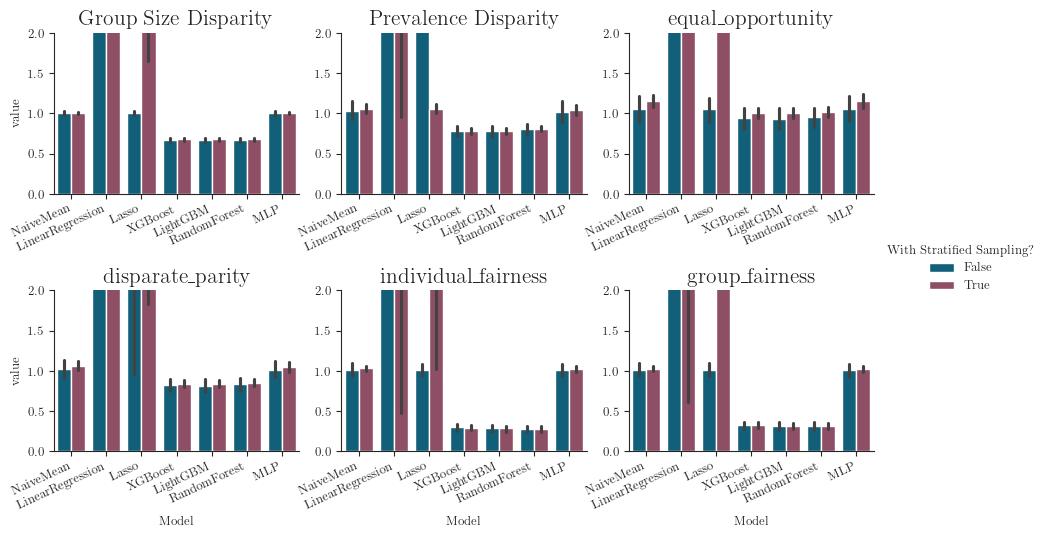

In [17]:
g=sns.FacetGrid(RMSE_result_df, col="label", col_wrap=3,sharey=False,sharex=False, height=2.5, aspect= 1.2)
g.map_dataframe(sns.barplot,x="Model",y="value",hue="balanced",estimator="mean",legend="auto",palette=COLORS)
models=RMSE_result_df["Model"].unique()
for ax, (_, subdata) in zip(g.axes.flat, g.facet_data()):
        #sns.barplot(subdata,x="Model",y="value",hue="balanced",estimator="mean",ax=ax)
        label=subdata["label"].unique()[0]
        ax.set_ylim((0,2))
        ax.set_title(label,fontsize="xx-large")
        for label in ax.get_xticklabels():
                label.set_rotation(25)
                label.set_ha('right')
        #ax.axhline(y=individual_average_df[individual_average_df["label"]==label][metrics].iloc[0], color='r', linestyle='-')
g.figure.subplots_adjust(hspace=0.6)
g.add_legend(title="With Stratified Sampling?")
plt.savefig(f"plots/Q2b/stratified.eps",bbox_inches="tight")
plt.savefig(f"plots/Q2b/stratified.pdf",bbox_inches="tight")

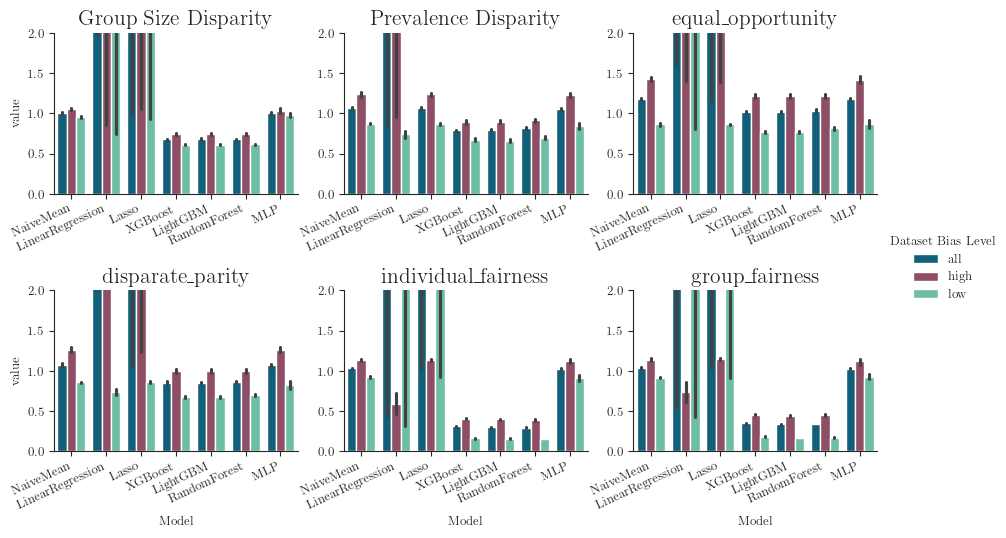

In [18]:
balanced_result_df=RMSE_result_df[RMSE_result_df["balanced"]==True]

g=sns.FacetGrid(balanced_result_df, col="label", col_wrap=3,sharey=False,sharex=False, height=2.5, aspect= 1.2)
g.map_dataframe(sns.barplot,x="Model",y="value",hue="on",estimator="mean",legend="auto",palette=COLORS)
models=balanced_result_df["Model"].unique()
for ax, (_, subdata) in zip(g.axes.flat, g.facet_data()):
        #sns.barplot(subdata,x="Model",y="value",hue="balanced",estimator="mean",ax=ax)
        label=subdata["label"].unique()[0]
        ax.set_ylim((0,2))
        ax.set_title(label,fontsize="xx-large")
        for label in ax.get_xticklabels():
                label.set_rotation(25)
                label.set_ha('right')
        #ax.axhline(y=individual_average_df[individual_average_df["label"]==label][metrics].iloc[0], color='r', linestyle='-')
g.figure.subplots_adjust(hspace=0.6)
g.add_legend(title="Dataset Bias Level")
plt.savefig(f"plots/Q2b/stratified_balanced.eps",bbox_inches="tight")
plt.savefig(f"plots/Q2b/stratified_balanced.pdf",bbox_inches="tight")

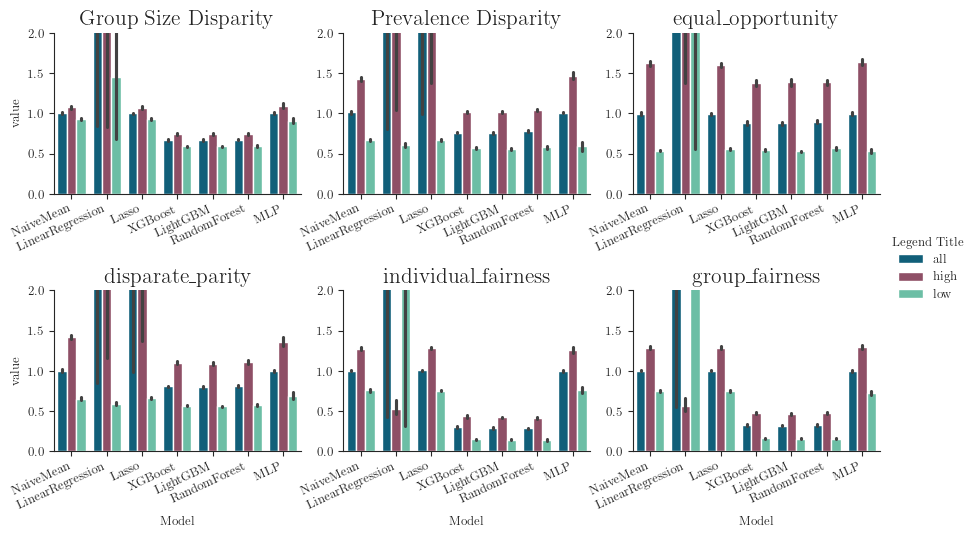

In [19]:
unbalanced_result_df=RMSE_result_df[RMSE_result_df["balanced"]==False]

g=sns.FacetGrid(unbalanced_result_df, col="label", col_wrap=3,sharey=False,sharex=False, height=2.5, aspect= 1.2)
g.map_dataframe(sns.barplot,x="Model",y="value",hue="on",estimator="mean",legend="auto",palette=COLORS)
models=unbalanced_result_df["Model"].unique()
for ax, (_, subdata) in zip(g.axes.flat, g.facet_data()):
        #sns.barplot(subdata,x="Model",y="value",hue="balanced",estimator="mean",ax=ax)
        label=subdata["label"].unique()[0]
        ax.set_ylim((0,2))
        ax.set_title(label,fontsize="xx-large")
        for label in ax.get_xticklabels():
                label.set_rotation(25)
                label.set_ha('right')
        #ax.axhline(y=individual_average_df[individual_average_df["label"]==label][metrics].iloc[0], color='r', linestyle='-')
g.figure.subplots_adjust(hspace=0.6)
g.add_legend(title="Legend Title")
plt.savefig(f"plots/Q2b/stratified_unbalanced.eps",bbox_inches="tight")
plt.savefig(f"plots/Q2b/stratified_unbalanced.pdf",bbox_inches="tight")